In [ ]:
!pip install nlpaug
!pip install ktrain
!pip install tensorflow
!pip install transformers

# Importing necessary libraries
import numpy as np
import pandas as pd
import tensorflow as tf
import re
import string
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
import nlpaug.augmenter.word as naw

# Mount Google Drive (only applicable in Google Colab)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Load the dataset
path = 'drive/My Drive/Colab Notebooks/private-data/text_data'
df = pd.read_excel(path + '/private_data.xlsx')

# Function for basic text cleaning
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

# Data preprocessing
df['text'] = df['text'].astype(str)
indexes_to_drop = df[df['label'].isin(['|', '11', '22', '32', '21'])].index
df.drop(indexes_to_drop, inplace=True)
df['label'] = pd.to_numeric(df['label'], errors='coerce')
df.dropna(subset=['label'], inplace=True)
df['label'] = df['label'].astype('int32')
df = df.drop_duplicates(subset='text', keep='first')
df['text'] = df['text'].apply(clean_text)

# Augmentation function
def augment_text(df, augmenter, repetitions=1):
    aug_texts = []
    for _, row in df.iterrows():
        text = row['text']
        for _ in range(repetitions):
            augmented_text = augmenter.augment(text)
            aug_texts.append((augmented_text, row['label']))
    return pd.DataFrame(aug_texts, columns=['text', 'label'])

# Synonym Augmenter
augmenter = naw.SynonymAug(aug_src='wordnet')

# Upsampling using augmentation
max_size = df['label'].value_counts().max()
df_balanced = pd.DataFrame()
for label in df['label'].unique():
    df_class = df[df['label'] == label]
    df_class_aug = augment_text(df_class, augmenter, repetitions=max_size // len(df_class) - 1)
    df_balanced = pd.concat([df_balanced, df_class, df_class_aug])


# Print class distribution after augmentation
print("\nClass distribution after augmentation:")
print(df_balanced['label'].value_counts())


# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=123).reset_index(drop=True)



# Define class names
class_names = ['0', '1', '2', '3']

# Tokenizer from transformers
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Function to encode texts
def encode_texts(tokenizer, texts, max_length=256):
    input_ids = []
    attention_masks = []

    for text in texts:
        text = str(text)
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf',
        )

        input_ids.append(encoded['input_ids'][0])
        attention_masks.append(encoded['attention_mask'][0])

    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_masks)

# Splitting the data
X_train, X_temp, y_train, y_temp = train_test_split(df_balanced['text'], df_balanced['label'], test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Encoding the data
train_inputs, train_masks = encode_texts(tokenizer, X_train)
val_inputs, val_masks = encode_texts(tokenizer, X_val)
test_inputs, test_masks = encode_texts(tokenizer, X_test)

# Converting labels to tensors
train_labels = tf.convert_to_tensor(y_train.to_numpy().astype('int32'))
val_labels = tf.convert_to_tensor(y_val.to_numpy().astype('int32'))
test_labels = tf.convert_to_tensor(y_test.to_numpy().astype('int32'))

# Model initialization
model = TFRobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=len(class_names))

# Model compilation
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Defining batch size
batch_size = 20

# Model training with validation data and early stopping
history = model.fit(
    [train_inputs, train_masks],
    train_labels,
    batch_size=batch_size,
    validation_data=([val_inputs, val_masks], val_labels),  # Including validation data
    epochs=20,
    callbacks=[early_stopping]
)

# Print the training and validation loss and accuracy for each epoch
print("Training Loss per Epoch:", history.history['loss'])
print("Training Accuracy per Epoch:", history.history['accuracy'])
print("Validation Loss per Epoch:", history.history['val_loss'])
print("Validation Accuracy per Epoch:", history.history['val_accuracy'])

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([test_inputs, test_masks], test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Save the model
#model.save_pretrained('/content/drive/My Drive/Colab Notebooks/public-data/models/roberta-cyberbullying-classifier')



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 42.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.41.3-py3-none-any.whl size=25316960 sha256=d8e38d356dfa60cf69f2a16bbc0632660bb6e4bcde1df3920fc7b1a92fc2db7b
  Stored in directory: /root/.cache/pip/wheels/fc/76/11/5b953090ee

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.



Class distribution after augmentation:
label
0    8130
2    8128
3    7952
1    7536
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/20


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1270/1270 [==============================] - 1497s 1s/step - loss: 0.3361 - accuracy: 0.8704 - val_loss: 0.1262 - val_accuracy: 0.9537
Epoch 2/20
1270/1270 [==============================] - 1376s 1s/step - loss: 0.1020 - accuracy: 0.9652 - val_loss: 0.0779 - val_accuracy: 0.9732
Epoch 3/20
1270/1270 [==============================] - 1375s 1s/step - loss: 0.0590 - accuracy: 0.9802 - val_loss: 0.0806 - val_accuracy: 0.9767
Epoch 4/20
1270/1270 [==============================] - 1402s 1s/step - loss: 0.0422 - accuracy: 0.9852 - val_loss: 0.0632 - val_accuracy: 0.9817
Epoch 5/20
1270/1270 [==============================] - 1402s 1s/step - loss: 0.0336 - accuracy: 0.9889 - val_loss: 0.0682 - val_accuracy: 0.9811
Epoch 6/20
1270/1270 [==============================] - 1376s 1s/step - loss: 0.0266 - accuracy: 0.9922 - val_loss: 0.0648 - val_accuracy: 0.98

# **Performance Evaluation**

100/100 [==============================] - 65s 562ms/step
Confusion Matrix:
[[772  29   3   1]
 [ 10 756   4   1]
 [  6   2 794   0]
 [  2   0   0 795]]
Precision: 0.9818203874630149
Recall: 0.981732283464567
F1 Score: 0.9817296723203551


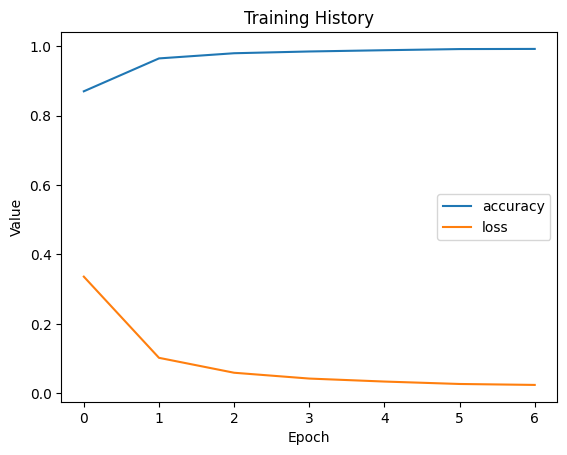

In [ ]:

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt


# Evaluate the model on the test set
predictions = model.predict([test_inputs, test_masks])[0]
predicted_classes = np.argmax(predictions, axis=1)


y_test_np = np.array(y_test).astype('int32')


cm = confusion_matrix(y_test_np, predicted_classes)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_np, predicted_classes, average='weighted')

print(f'Confusion Matrix:\n{cm}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}')

# Plotting training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.title('Training History')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend()
plt.show()



# Confusion Matrix

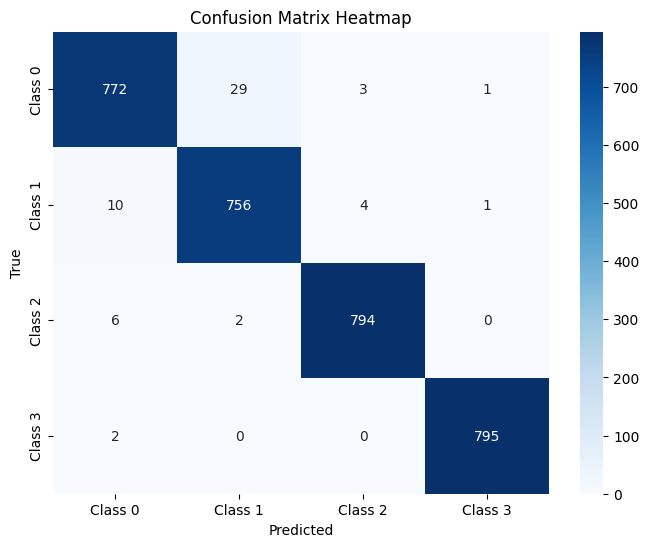

In [ ]:
y_test_np = np.array(y_test).astype('int32')
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


# Calculate confusion matrix
cm = confusion_matrix(y_test_np, predicted_classes)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()



# ROC-AUC

100/100 [==============================] - 55s 554ms/step


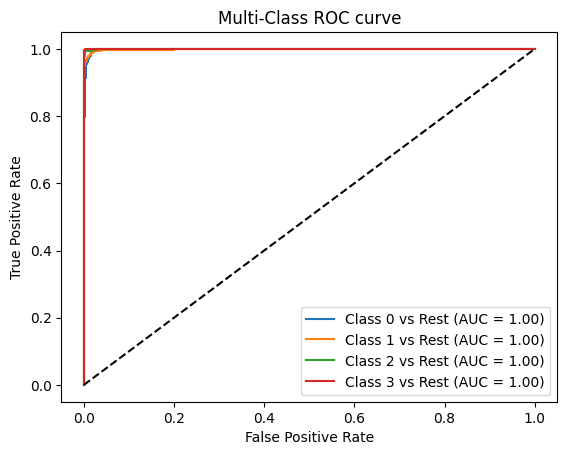

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

# Predict probabilities
pred_probabilities = model.predict([test_inputs, test_masks])
preds = tf.nn.softmax(pred_probabilities.logits).numpy()

# For multi-class, calculate ROC curve and ROC AUC for each class
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()
n_class = len(class_names)

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(to_categorical(y_test, num_classes=n_class)[:,i], preds[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting
for i in range(n_class):
    plt.plot(fpr[i], tpr[i], linestyle='-', label=f'Class {i} vs Rest (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC curve')
plt.legend(loc='best')
plt.show()


# **Performance evalution  for each labels**

100/100 [==============================] - 55s 552ms/step
Metrics for Class 0:
Precision: 0.9772151898734177
Recall: 0.9590062111801242
F1 Score: 0.968025078369906
Accuracy: 0.9839370078740157



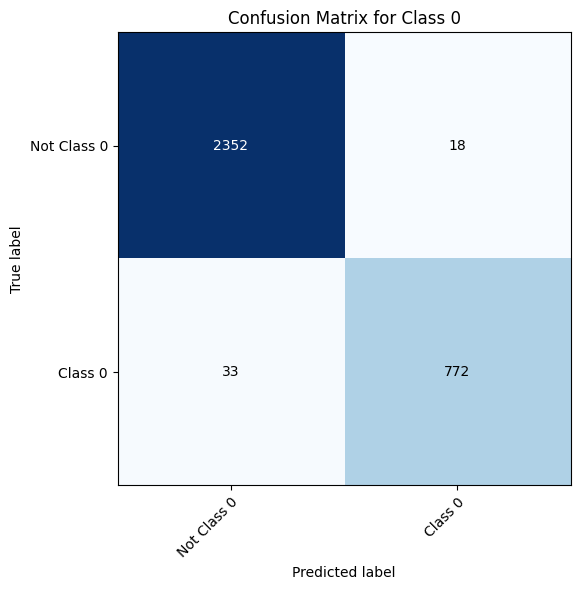

Metrics for Class 1:
Precision: 0.9606099110546379
Recall: 0.980544747081712
F1 Score: 0.9704749679075738
Accuracy: 0.9855118110236221



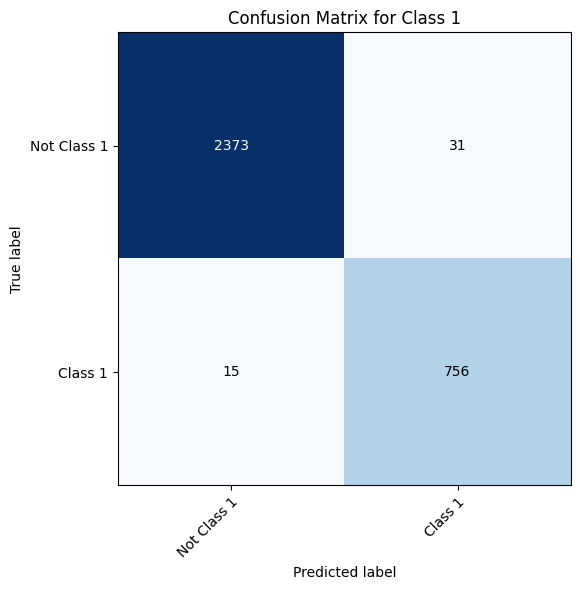

Metrics for Class 2:
Precision: 0.9912609238451935
Recall: 0.9900249376558603
F1 Score: 0.990642545227698
Accuracy: 0.9952755905511811



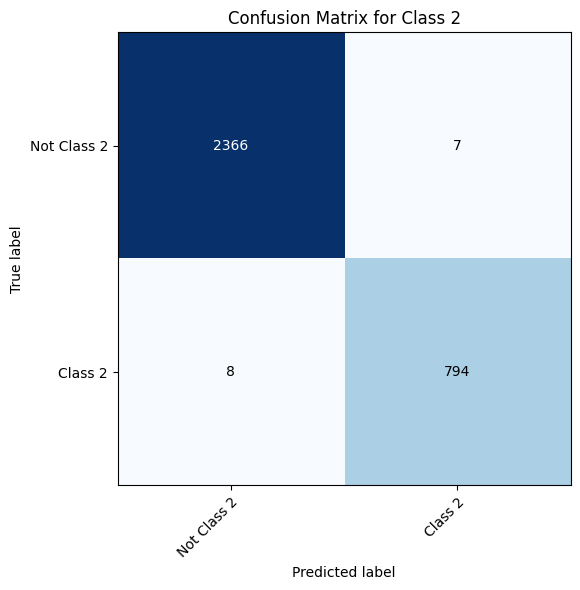

Metrics for Class 3:
Precision: 0.9974905897114178
Recall: 0.9974905897114178
F1 Score: 0.9974905897114178
Accuracy: 0.998740157480315



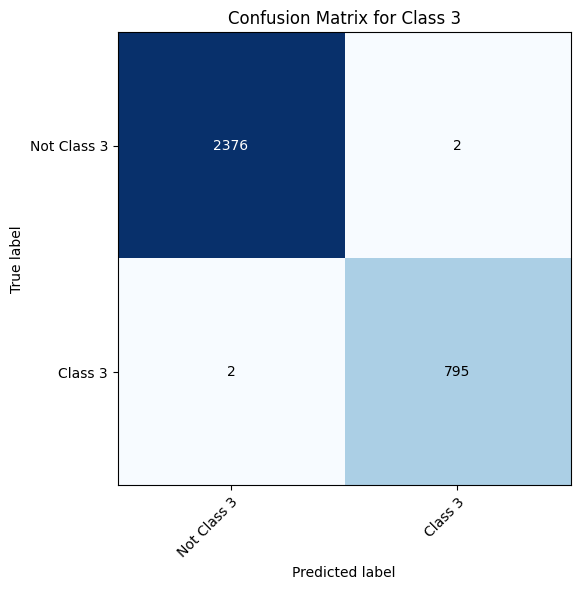

In [ ]:
# Predictions
test_predictions = model.predict([test_inputs, test_masks])
test_predictions = np.argmax(test_predictions.logits, axis=1)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, class_index, class_names):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set(xticks=np.arange(2),
           yticks=np.arange(2),
           xticklabels=[f'Not Class {class_index}', f'Class {class_index}'],
           yticklabels=[f'Not Class {class_index}', f'Class {class_index}'],
           title=f'Confusion Matrix for Class {class_names[class_index]}',
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()

# Display metrics and confusion matrix for each class
for class_index in range(len(class_names)):
    true_binary = (y_test == class_index)
    pred_binary = (test_predictions == class_index)
    conf_matrix = confusion_matrix(true_binary, pred_binary, labels=[False, True])

    precision, recall, f1, _ = precision_recall_fscore_support(true_binary, pred_binary, labels=[False, True])

    # Calculate accuracy
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

    print(f"Metrics for Class {class_index}:")
    print(f"Precision: {precision[1]}")
    print(f"Recall: {recall[1]}")
    print(f"F1 Score: {f1[1]}")
    print(f"Accuracy: {accuracy}\n")

    plot_confusion_matrix(conf_matrix, class_index, class_names)

# Save the model
#model.save_pretrained('/content/drive/My Drive/Colab Notebooks/public-data/models/roberta-cyberbullying-classifier')


# Save test result in the csv file

In [ ]:


# Load unlabelled data (assuming the text is in a column named 'text')
unlabelled_path = '/content/drive/My Drive/Colab Notebooks/public-data/text_data/test_data.csv'
unlabelled_df = pd.read_csv(unlabelled_path)

# Process the unlabelled text data
unlabelled_texts = unlabelled_df['text'].astype(str).tolist()

unlabelled_inputs, unlabelled_masks = encode_texts(tokenizer, unlabelled_texts)

# Get model predictions
predictions = model.predict([unlabelled_inputs, unlabelled_masks], verbose=1)
predicted_class_probs = tf.nn.softmax(predictions.logits).numpy()
predicted_classes = np.argmax(predicted_class_probs, axis=1)

# Prepare to save predictions to CSV
predictions_with_values = pd.DataFrame({
    'text': unlabelled_texts,
    'predicted_label': predicted_classes,
    'predicted_value': np.max(predicted_class_probs, axis=1)
})

# Save the predictions to a CSV file
predictions_save_path = '/content/drive/My Drive/Colab Notebooks/private-data/text_data/predictions.csv'
predictions_with_values.to_csv(predictions_save_path, index=False)

print("Predictions with values written to", predictions_save_path)


56/56 [==============================] - 30s 534ms/step
Predictions with values written to /content/drive/My Drive/Colab Notebooks/private-data/text_data/predictions.csv


In [ ]:
# Save the model
model.save_pretrained('/content/drive/My Drive/Colab Notebooks/private-data/models/roberta-cyberbullying-classifier')